## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
import matplotlib.pyplot as plt

In [3]:
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize;

In [46]:
!pip install xgboost

## Load Data sets

In [4]:
info_df = pd.read_csv('/home/rupeek/Desktop/ML &AI/Fake news detection/news.csv')
info_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Explore the Data

In [7]:
#instantiate CountVectorizer()
cv=CountVectorizer()#create matrix dXm(doc and words)
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(info_df["text"])
 

In [8]:
word_count_vector.shape

(6335, 67659)

In [9]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_vector = tfidf_transformer.fit_transform(word_count_vector)

In [10]:
cv.get_feature_names()

['00',
 '000',
 '0000',
 '000000031',
 '00000031',
 '000035',
 '00006',
 '0001',
 '0001pt',
 '0002',
 '000billion',
 '000ft',
 '000km',
 '000x',
 '001',
 '0011',
 '002',
 '003',
 '004',
 '004s',
 '005',
 '005s',
 '006',
 '00684',
 '006s',
 '007',
 '007s',
 '008',
 '008s',
 '009',
 '0099',
 '00am',
 '00p',
 '00pm',
 '01',
 '010',
 '011',
 '012',
 '013',
 '013c2812c9',
 '014',
 '015',
 '016',
 '018',
 '01am',
 '02',
 '020',
 '022',
 '023',
 '024',
 '025',
 '027',
 '02714',
 '028',
 '02870',
 '02welcome',
 '03',
 '030',
 '031',
 '032',
 '0325',
 '033',
 '034',
 '035',
 '037',
 '03747',
 '039',
 '03eb',
 '04',
 '040',
 '0400',
 '042',
 '044',
 '047',
 '048',
 '049',
 '04pm',
 '05',
 '050',
 '0509245d29',
 '052',
 '053',
 '056',
 '058',
 '06',
 '0600',
 '062',
 '063',
 '0640',
 '066',
 '068',
 '06pm',
 '07',
 '0700',
 '071',
 '075',
 '0750',
 '076',
 '079',
 '07dryempjx',
 '08',
 '080',
 '081',
 '082',
 '084',
 '0843',
 '085',
 '0851',
 '089',
 '0891',
 '09',
 '091',
 '093',
 '098263',
 '09

In [11]:
feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
fbi,0.445587
the,0.413941
comey,0.200964
that,0.169762
of,0.166296
...,...
fcs,0.000000
fd,0.000000
fda,0.000000
fdd,0.000000


In [15]:
data_text = info_df[['text']].astype('str')

In [16]:
data_text.shape

(6335, 1)

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/rupeek/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stopw=stopwords.words('english')
stopw
def stopwords_remove(x):
    terms=x.split()#get the words
    terms=[w for w in terms if w not in stopw]#if word isnt possible in stopw
    sentence=' '.join(terms)#joining words after stopword removal
    return sentence
data_text['Refined_text']=data_text['text'].apply(lambda x: stopwords_remove(x))

In [23]:
def word_count(x):#no. of terms in data
    terms = x.split()
    return len(terms)
data_text['Word_Count']=data_text['Refined_text'].apply(lambda x: word_count(x))

In [24]:
data_text.head()

,text,Refined_text,Word_Count
0,"Daniel Greenfield, a Shillman Journalism Fello...","Daniel Greenfield, Shillman Journalism Fellow ...",765
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,Google Pinterest Digg Linkedin Reddit Stumbleu...,272
2,U.S. Secretary of State John F. Kerry said Mon...,U.S. Secretary State John F. Kerry said Monday...,259
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...","— Kaydee King (@KaydeeKing) November 9, 2016 T...",277
4,It's primary day in New York and front-runners...,It's primary day New York front-runners Hillar...,197


In [25]:
data_text['Word_Count'].describe()

count     6335.000000
mean       480.641515
std        519.722037
min          0.000000
25%        182.000000
50%        373.000000
75%        628.000000
max      12212.000000
Name: Word_Count, dtype: float64

## Evaluation of mode

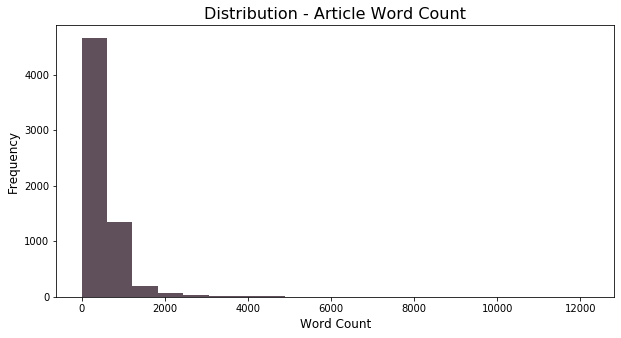

In [26]:
fig = plt.figure(figsize=(10,5))

plt.hist(
    data_text['Word_Count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

In [27]:
headline_sentences=[''.join(text) for text in data_text['Refined_text']]

In [28]:
vectorizer = CountVectorizer(max_features=5000)#top 5000 words;co occurance matrix creation
#x_counts = vectorizer.fit_transform(headline_sentences)

In [29]:
#x_counts

<6335x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1502713 stored elements in Compressed Sparse Row format>

In [30]:
transformer = TfidfTransformer(smooth_idf=False);#transformer
x_tfidf = transformer.fit_transform(x_counts);

In [32]:
import os
a = os.listdir('/home/rupeek/Desktop/ML &AI/Fake news detection/sentences_tokenized/')
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

a = sorted_aphanumeric(a)
b =[]
for i in a:
    i = 'sentences_tokenized/'+i
    b.append(str(i)) 
vect_matrix = vectorizer.fit_transform(headline_sentences)

In [33]:
vect_matrix.shape


(6335, 5000)

## Training and Testing the data

In [34]:
train_features, test_features = vect_matrix[:400,],vect_matrix[401:563,]
train_labels, test_labels = info_df['label'][:400] , info_df['label'][401:563]

### Conclusion

## Logistic regression

In [35]:
logistic = linear_model.LogisticRegression()

logr= logistic.fit(train_features,train_labels)

In [53]:
ac0=logr.score(test_features,test_labels)
print("Accuracy: %.2f%%" % (ac0 * 100.0))

Accuracy: 87.65%


[[69 12]
 [ 8 73]]


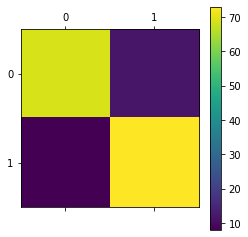

In [37]:
pred = logr.predict(test_features)
labels = ['x', 'y']
cm = confusion_matrix(test_labels, pred)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [38]:
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

        FAKE       0.90      0.85      0.87        81
        REAL       0.86      0.90      0.88        81

    accuracy                           0.88       162
   macro avg       0.88      0.88      0.88       162
weighted avg       0.88      0.88      0.88       162



## Multinomial classifier

In [52]:
mnb = MultinomialNB()
mnb.fit(train_features,train_labels)
ac1=mnb.score(test_features,test_labels)
print("Accuracy: %.2f%%" % (ac1 * 100.0))

Accuracy: 84.57%


[[63 18]
 [ 7 74]]


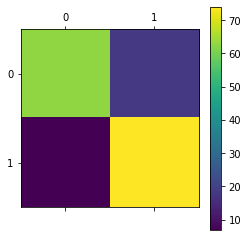

In [40]:
pred = mnb.predict(test_features)
labels = ['x', 'y']
cm = confusion_matrix(test_labels, pred)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [41]:
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

        FAKE       0.90      0.78      0.83        81
        REAL       0.80      0.91      0.86        81

    accuracy                           0.85       162
   macro avg       0.85      0.85      0.84       162
weighted avg       0.85      0.85      0.84       162



## Random forest classifier

In [42]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_features,train_labels)
clf.score(test_features,test_labels)


0.7716049382716049

[[52 29]
 [ 8 73]]


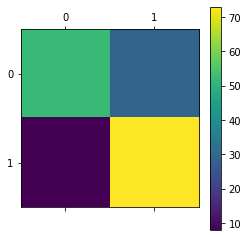

Accuracy: 77.16%


In [51]:
pred2 = clf.predict(test_features)
labels = ['x', 'y']
cm = confusion_matrix(test_labels, pred2)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()
ac2 = accuracy_score(test_labels, pred2)
print("Accuracy: %.2f%%" % (ac2 * 100.0))

In [44]:
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

        FAKE       0.87      0.64      0.74        81
        REAL       0.72      0.90      0.80        81

    accuracy                           0.77       162
   macro avg       0.79      0.77      0.77       162
weighted avg       0.79      0.77      0.77       162



## XGB classifier

In [50]:
model = XGBClassifier()
model.fit(train_features, train_labels)
y_pred = model.predict(test_features)
predictions = [value for value in y_pred]
ac3 = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (ac3 * 100.0))

Accuracy: 80.25%


[[58 23]
 [ 9 72]]


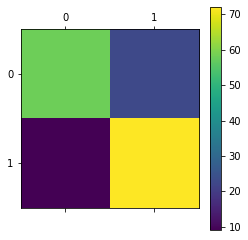

In [48]:
pred = model.predict(test_features)
labels = ['x', 'y']
cm = confusion_matrix(test_labels, pred)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [49]:
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

        FAKE       0.87      0.72      0.78        81
        REAL       0.76      0.89      0.82        81

    accuracy                           0.80       162
   macro avg       0.81      0.80      0.80       162
weighted avg       0.81      0.80      0.80       162



## Accuracy

In [ ]:
accuracy=[ac0,ac1,ac2,ac3]
classifiers=['LogisticRegression','MNB','RFC','XGB']
summ = pd.DataFrame({'accuracy':accuracy}, index= classifiers)
summ

Accuracy of models


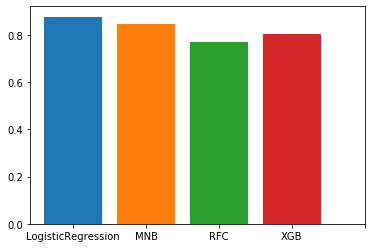

In [55]:
print("Accuracy of models")

plt.bar(0,ac0)
plt.bar(1,ac1)
plt.bar(2,ac2)
plt.bar(3,ac3)

plt.xticks([0,1,2,3,4], ['LogisticRegression','MNB','RFC','XGB'])
plt.show()